In [146]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [147]:
# function of img show
def imshow(image):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    else:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [148]:
# estimate the homography matrix H with 4 or more corresponding point pairs
def estimate_homography(point1,point2):
    
    num = len(point1)
    
    A = []
    
    # each point correspondence generate 2 equations
    for i in range(num):
        x1 = point1[i][0]
        y1 = point1[i][1]
        x2 = point2[i][0]
        y2 = point2[i][1]
        A.append([x1, y1, 1, 0, 0, 0, -x2*x1, -x2*y1, -x2])
        A.append([0, 0, 0, x1, y1, 1, -y2*x1, -y2*y1, -y2])
        
    A = np.asarray(A)
    # compute the SVD of A
    U, D, VT = np.linalg.svd(A, full_matrices=True)
    # take the rightmost column of V which corresponds to the smallest singular value
    H = VT[-1, :]
    # reshape H into a 3*3 matrix
    H = np.reshape(H, (3, 3))
    
    return H

the homography matrix:
[[-1.99961583e-03 -8.33173262e-05  9.08158857e-01]
 [-4.55951195e-04 -6.41181368e-04  4.18620191e-01]
 [-6.64889910e-07 -5.79044255e-08  4.68403274e-05]]


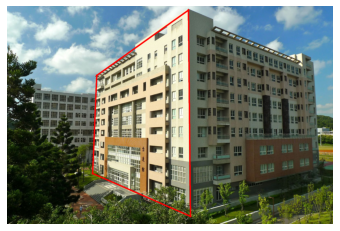

In [149]:
# select 4 point correspondence
selected_img = cv2.imread('./Delta-Building.jpg')
h = selected_img.shape[0]
w = selected_img.shape[1]

rectified_img = np.zeros((h,w,3),dtype = np.uint8)

# choose 4 point and draw line
cv2.circle(selected_img,(440,340), 5, (0, 0, 255), -1)
cv2.circle(selected_img,(890,20), 5, (0, 0, 255), -1)
cv2.circle(selected_img,(900,1030), 5, (0, 0, 255), -1)
cv2.circle(selected_img,(420,820), 5, (0, 0, 255), -1)

cv2.line(selected_img, (440,340), (890,20), (0, 0, 255), 5)
cv2.line(selected_img, (890,20), (900,1030), (0, 0, 255), 5)
cv2.line(selected_img, (900,1030), (420,820), (0, 0, 255), 5)
cv2.line(selected_img, (420,820), (440,340), (0, 0, 255), 5)

cv2.imwrite('./output/selected_img.jpg',selected_img)

# original: point1 -> (440,340), point2 -> (890,20), point3 -> (900,1030), point4 -> (420,820)
original_pt = [[440,340],[890,20],[900,1030],[420,820]]
# rectified: point1 -> (0,0), point2 -> (w-1,0), point3 -> (w-1,h-1), point4 -> (0,h-1)
rectified_pt = [[0,0],[w-1,0],[w-1,h-1],[0,h-1]]

H = estimate_homography(original_pt,rectified_pt)
print('the homography matrix:')
print(H)
imshow(selected_img)

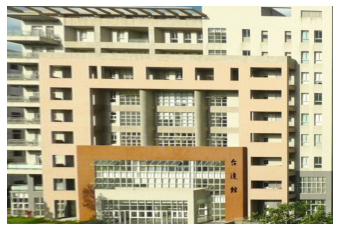

True

In [150]:
# image rectification
original_img = cv2.imread('./Delta-Building.jpg')
# take inverse of matrix H to do backward warping
H_inv = np.linalg.inv(H)

for i in range(rectified_img.shape[0]):
    for j in range(rectified_img.shape[1]):
        # calculate corresponding pixel in original image
        pixel = H_inv.dot(np.array([j,i,1]))
        pixel /= pixel[2]
        x = pixel[0]
        y = pixel[1]
        
        # Bilinear interpolation
        a = x - int(x)
        b = int(y) + 1 - y
        value = (1-a)*(1-b)*original_img[int(y) + 1][int(x)]
        value += a*(1-b)*original_img[int(y) + 1][int(x) + 1]
        value += a*b*original_img[int(y)][int(x) + 1]
        value += (1-a)*b*original_img[int(y)][int(x)] 
        
        rectified_img[i][j] = value
        
imshow(rectified_img)
cv2.imwrite('./output/rectified_img.jpg',rectified_img)